In [1]:
from biom import load_table, Table
import pandas as pd
from skbio import DistanceMatrix
import qiime2 as q2
import numpy as np
from scipy.stats import spearmanr, pearsonr
# Ensure gemelli v.0.0.10 is installed
from gemelli.rpca import rpca_with_cv
from gemelli.utils import qc_rarefaction
from gemelli.q2.tests.test_rpca_method import create_pos_cntrl_test_table
np.random.seed(42)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('ggplot')
%matplotlib inline

## Introduction

There have been a lot of valid questions about how to choose parameters in RPCA (see here) & if rarefaction is not necessary (see here). To help answer these questions two new QC functionalities have been added to RPCA (and the subsequent tools here).

First, a cross-validation method has been added where a hold-out set is used to determine the cross-validation error reduction across pre-processing steps or parameters. This is calculated by comparing the error in the reconstruction of the data from the projection (produced from the non-hold-out data) of the hold-out set to the original data of the hold-out data. This is done for each iteration of the least squares minimization of the OptSpace algorithm used in RPCA. By default, this method will randomly choose 10 samples to hold out but you can specify any number or provide additional metadata to RPCA to specify train and test samples.  

Second, a test to see if rarefaction leads to a significantly lower correlation to the absolute differences in sample sums has been added. This works by generating RPCA distances with or without rarefying (or rarefaction with many iterations of rarefying). The mantel correlation of the absolute sample sum differences and each distance is calculated, along with the mantel correlation between both distances and then the Steiger test is performed. Rarefaction is mandatory if both the unrarefied mantel correlation is significant and the Steiger test is significant (t<0 & p<alpha).


### Toy / Simulation Example

As an example, let's assume two underlying rank 3 datasets (created using a gaussian block and then converted to counts by Poisson log-normal sampling) and then a "positive" control where each block has a larger total sum than the previous one (this would match case 9 in [this paper](https://journals.asm.org/doi/epdf/10.1128/msphere.00355-23)). 

Note: if you are using `auto-rpca` we have depreciated the rank-estimation function and it has been replaced by these QC metrics.


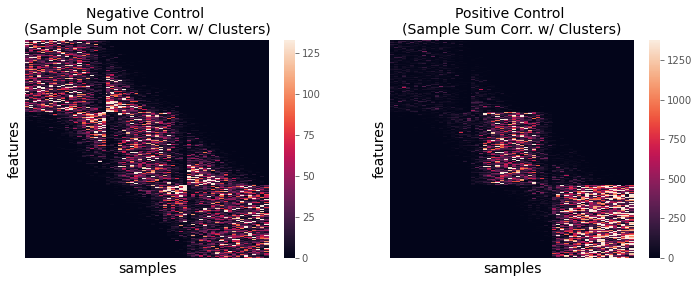

In [51]:
# generate some small example data
sim_table, sim_positive_control = create_pos_cntrl_test_table(n_clust=3,
                                                              n_feat=300,
                                                              n_samp=60,
                                                              seq_base=3000,
                                                              multiple_inc = 10)
# multiple_inc=10

# plot that example data
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(sim_table.matrix_data.toarray(), robust=True, 
            ax=axn[0], xticklabels=False, yticklabels=False)

sns.heatmap(sim_positive_control.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)

axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('Negative Control \n(Sample Sum not Corr. w/ Clusters)', color='black', fontsize=14)

axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('Positive Control \n(Sample Sum Corr. w/ Clusters)', color='black', fontsize=14)

plt.show()


This leads to an obvious problem in the positive control (right) where, without knowing this was the case, you would need to rarefy. So let's test that the new QC functions work. While the original simulation (left) has sample sums more randomly distributed across the blocks. This code block takes a few minutes to run (~8-10 min on a Macbook).

In [52]:
def rarefaction_compare(bt, n_rarefy = 100):
    """
    Quick helper function for running QC examples.
    
    bt: biom.Table
    Table to run.
    
    n_rarefy: int
    Number of time to rarefy.
    """
    test_results = {}
    cv_rare_all = []
    cv_norare_all = []
    for i in range(n_rarefy):
        # make sure the hold out samples are the same
        mf_mock = pd.DataFrame(['train'] * len(bt.ids()), 
                               bt.ids(),
                               ['train_test'])
        mf_mock.loc[mf_mock.sample(int(mf_mock.shape[0] * 0.2)).index, 'train_test'] = 'test'  
        # run unrare data
        rare_level = int(min(bt.sum('sample')) - 1)
        ord_norare, dist_norare, cv_norare = rpca_with_cv(bt,
                                                          min_sample_count=rare_level,
                                                          sample_metadata=mf_mock,
                                                          train_test_column='train_test')   
        cv_norare_all.append(cv_norare)
        # rarefy data and rerun
        ord_rare, dist_rare, cv_rare = rpca_with_cv(bt.subsample(rare_level),
                                                    sample_metadata=mf_mock,
                                                    train_test_column='train_test')
        # qc the data
        t_, p_, xy, p_xy, xz, pxz_, _, _ = qc_rarefaction(bt, 
                                                          dist_rare, 
                                                          dist_norare, 
                                                          return_mantel=True)
        # save the results
        cv_rare_all.append(cv_rare)
        test_results[i] = [t_, p_, xy, p_xy, xz, pxz_]
    columns_ = ['steiger_t_coeff', 'steiger_p',
                'rarefaction_mantel_coeff', 
                'rarefaction_mantel_p',
                'no_rarefaction_mantel_coeff', 
                'no_rarefaction_mantel_p']
    test_results = pd.DataFrame(test_results, columns_).T
    test_results.index.name = 'iteration'
    return (pd.concat(cv_norare_all), pd.concat(cv_rare_all), test_results)


In [53]:
# run for the negative control
neg_control_results = rarefaction_compare(sim_table)
# run for the positive control
pos_control_results = rarefaction_compare(sim_positive_control)


/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/rpca.py:904: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  % (unshared_N), RuntimeWarning)


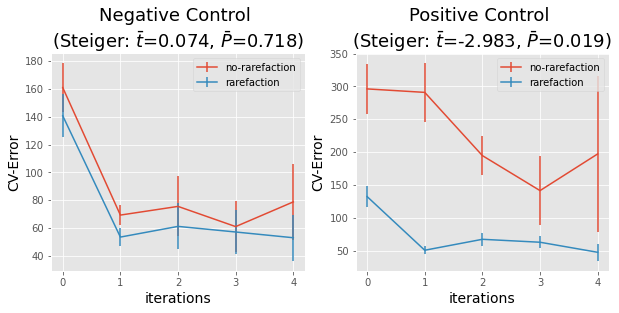

In [54]:
fig, axn = plt.subplots(1, 2, figsize=(10, 4))

# plot unrarefied data mean and std.
cv_norare_all_df_mean = neg_control_results[0].groupby('iteration').mean()
cv_norare_all_df_std = neg_control_results[0].groupby('iteration').std()
axn[0].errorbar(x=cv_norare_all_df_mean.index,
            y=cv_norare_all_df_mean.mean_CV, 
            yerr=cv_norare_all_df_std.mean_CV,
            label='no-rarefaction')
# plot rarefied data mean and std.
cv_rare_all_df_mean = neg_control_results[1].groupby('iteration').mean()
cv_rare_all_df_std = neg_control_results[1].groupby('iteration').std()
axn[0].errorbar(x=cv_rare_all_df_mean.index,
            y=cv_rare_all_df_mean.mean_CV, 
            yerr=cv_rare_all_df_std.mean_CV,
            label='rarefaction')
axn[0].legend()
t_hat, p_hat = neg_control_results[2].mean().values[:2]
axn[0].set_title('Negative Control \n(Steiger: $\\bar{t}$=%.3f, $\\bar{P}$=%.3f)' % (t_hat, p_hat),
                 fontsize=18, color='black')
axn[0].set_xlabel('iterations', fontsize=14, color='black')
axn[0].set_ylabel('CV-Error', fontsize=14, color='black')

# plot unrarefied data mean and std.
cv_norare_all_df_mean = pos_control_results[0].groupby('iteration').mean()
cv_norare_all_df_std = pos_control_results[0].groupby('iteration').std()
axn[1].errorbar(x=cv_norare_all_df_mean.index,
            y=cv_norare_all_df_mean.mean_CV, 
            yerr=cv_norare_all_df_std.mean_CV,
            label='no-rarefaction')
# plot rarefied data mean and std.
cv_rare_all_df_mean = pos_control_results[1].groupby('iteration').mean()
cv_rare_all_df_std = pos_control_results[1].groupby('iteration').std()
axn[1].errorbar(x=cv_rare_all_df_mean.index,
            y=cv_rare_all_df_mean.mean_CV, 
            yerr=cv_rare_all_df_std.mean_CV,
            label='rarefaction')
axn[1].legend()
t_hat, p_hat = pos_control_results[2].mean().values[:2]
axn[1].set_title('Positive Control \n(Steiger: $\\bar{t}$=%.3f, $\\bar{P}$=%.3f)' % (t_hat, p_hat),
                 fontsize=18, color='black')
axn[1].set_xlabel('iterations', fontsize=14, color='black')
axn[1].set_ylabel('CV-Error', fontsize=14, color='black')

plt.show()


For the negative control, we can see there is not a large difference in the CV error values between rarefied and unrarefied data. The Steiger test (mean) is also not significant. Overall, as expected for the simulation data, this is a good example of when rarefaction probably is not necessary. However, on the right, there is a clear difference in the CV error, which is improved for the rarefied data. Moreover, the Steiger test is significant (t<0 & p<0.05). 


### Real data examples

Now the obvious question is how often is this the case in real data? To test this we ran 107 V4 16S studies through the same QC test (see qc-script.py). Let's take a look at the results. 

In [83]:
# Try on a lot of Qiita datasets
qc_results_testing_df_all = pd.read_csv('qc-rare-results-all.csv',
                                       index_col=0)
qc_results_testing_df_all.head(5)

,study_id,fold_rare,t,p,rare_mantel_r,unrare_mantel_r,rare_unrare_mantel_r
0,833,0,-0.747478,0.456202,0.037339,0.072809,0.860432
1,833,1,-0.690235,0.491347,0.035605,0.072809,0.820058
2,833,2,-1.177778,0.241159,0.018793,0.072809,0.868890
3,833,3,-1.098428,0.274163,0.030081,0.072809,0.905767
4,833,4,-0.895245,0.372405,0.034468,0.072809,0.886119


Here, for each table we have the Qiita study ID, the fold from rarefaction (0-99), the Steiger test t & p, followed by the mantel correlation between the unrarefied or rarefied RPCA output, and finally the mantel correlation between the rarefied vs. unrarefied distance from RPCA. Let's visualize the results. 

Out of 107 studies 2 require rarefaction (1.9%).


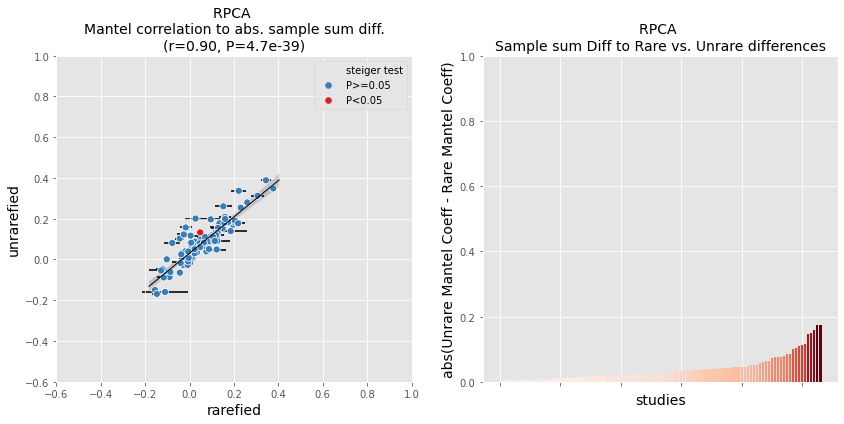

In [84]:
# summarize the results 
qc_results_testing_df_all_mean = qc_results_testing_df_all.groupby('study_id').mean()
qc_results_testing_df_all_sem = qc_results_testing_df_all.groupby('study_id').std()

# print some stats.
alpha = 0.05
n_sig = qc_results_testing_df_all_mean[(qc_results_testing_df_all_mean.p < alpha) 
                                       & (qc_results_testing_df_all_mean.t < 0)].shape[0]
percent_significant = 100 * (n_sig /qc_results_testing_df_all_mean.shape[0])
print('Out of %i studies %i require rarefaction (%.1f%%).' % (int(qc_results_testing_df_all_mean.shape[0]),
                                                             int(n_sig),
                                                             percent_significant))
# plot the summarized results
qc_results_testing_df_all_mean['steiger test'] = (qc_results_testing_df_all_mean.p < alpha) & (qc_results_testing_df_all_mean.t < 0)
qc_results_testing_df_all_mean['steiger test'] = qc_results_testing_df_all_mean['steiger test'].astype(str).str.replace('False', 'P>=0.05').replace('True', 'P<0.05')

fig, axn = plt.subplots(1, 2, figsize=(14, 6))

g = sns.regplot(x='rare_mantel_r', 
                y='unrare_mantel_r', 
                data=qc_results_testing_df_all_mean,
            scatter_kws={'s': 1}, line_kws={'lw':1}, 
                color='black', ax=axn[0], ci=95)
axn[0].errorbar(qc_results_testing_df_all_mean['rare_mantel_r'],
             qc_results_testing_df_all_mean['unrare_mantel_r'], 
             xerr=qc_results_testing_df_all_sem['rare_mantel_r'],
             linestyle="None", color='black', zorder=0, lw=2, alpha=0.8)
sns.scatterplot(x='rare_mantel_r', 
                y='unrare_mantel_r', 
                hue='steiger test',
                data=qc_results_testing_df_all_mean, 
                s=50, ax=axn[0], palette={'P>=0.05':'#377eb8',
                                          'P<0.05':'#e41a1c'})
axn[0].set_ylabel('unrarefied', fontsize=14, color='black')
axn[0].set_xlabel('rarefied', fontsize=14, color='black')
r_, p_ = pearsonr(qc_results_testing_df_all_mean['rare_mantel_r'], 
                     qc_results_testing_df_all_mean['unrare_mantel_r'])
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
else:
    p_   = "%.2f" % (p_)
axn[0].set_title('RPCA \nMantel correlation to abs. sample sum diff.\n(r=%.2f, P=%s)' % (r_, p_), 
          fontsize=14, color='black')

axn[0].set_ylim(-0.6, 1)
axn[0].set_xlim(-0.6, 1)

qc_results_testing_df_all['diff'] = abs(qc_results_testing_df_all.rare_mantel_r - qc_results_testing_df_all.unrare_mantel_r)
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
qc_results_testing_df_all = qc_results_testing_df_all.groupby('study_id').mean().sort_values('diff')
axn[1].bar(range(qc_results_testing_df_all.shape[0]), 
           qc_results_testing_df_all['diff'], 
           color=my_cmap(rescale(qc_results_testing_df_all['diff'])))
axn[1].set_xticklabels([])
axn[1].set_ylim(0, 1)
axn[1].set_ylabel('abs(Unrare Mantel Coeff - Rare Mantel Coeff)', fontsize=14, color='black')
axn[1].set_xlabel('studies', fontsize=14, color='black')
axn[1].set_title('RPCA \nSample sum Diff to Rare vs. Unrare differences', 
          fontsize=14, color='black')

plt.show()


As we can see, 2 out of the 107 studies (1.9%) had a significantly higher correlation to the sample sum difference in the unrarefied vs. rarefied RPCA input/output. This is not a negligible amount of studies and highlights the importance of cross-validation and QC when deciding on pre-processing steps. This is especially true for low-biomass studies which all of the significant studies are. However, the relationship between the unrarefied vs. the rarefied results when using RPCA is not extreme, the correlation between the two is very high. Even in the cases where the Steiger test is significant, the mantel correlation between the unrarefied distances and the absolute sample sum differences is small and not huge in magnitude from the rarefied distances (i.e., all <0.2).


Now, as an example of how the compositional transforms that RPCA uses to try to counteract these effects let's take a look at what it would look like if you did the same analysis with Bray-Curtis (which no one would advise is a good idea).  


Bray-Curtis: Out of 107 studies 82 require rarefaction (76.6%).


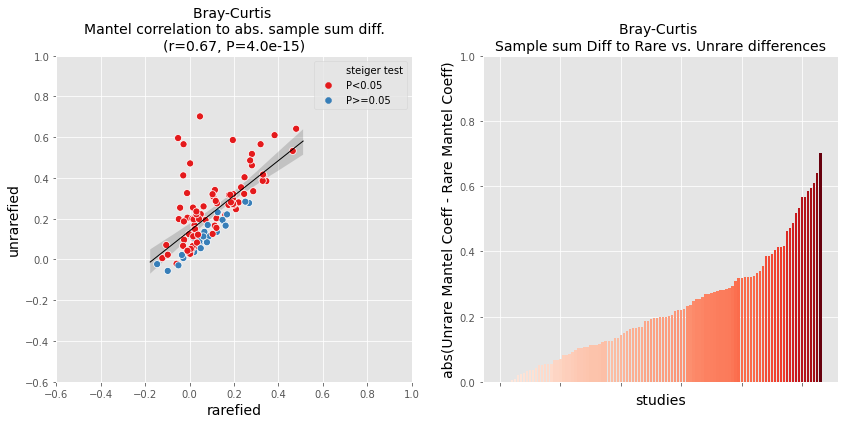

In [85]:
# Try on a lot of Qiita datasets
bc_testing_df_all = pd.read_csv('bc-qc-rare-results-all.csv',
                                index_col=0)
# summarize the results 
bc_qc_results_testing_df_all_mean = bc_testing_df_all.groupby('study_id').mean()
bc_qc_results_testing_df_all_sem = bc_testing_df_all.groupby('study_id').std()

# print some stats.
alpha = 0.05
n_sig = bc_qc_results_testing_df_all_mean[(bc_qc_results_testing_df_all_mean.p < alpha)].shape[0]
percent_significant = 100 * (n_sig /bc_qc_results_testing_df_all_mean.shape[0])
print('Bray-Curtis: Out of %i studies %i require rarefaction (%.1f%%).' % (int(bc_qc_results_testing_df_all_mean.shape[0]),
                                                             int(n_sig),
                                                             percent_significant))
# plot the summarized results
bc_qc_results_testing_df_all_mean['steiger test'] = bc_qc_results_testing_df_all_mean.p < alpha
bc_qc_results_testing_df_all_mean['steiger test'] = bc_qc_results_testing_df_all_mean['steiger test'].astype(str).str.replace('False', 'P>=0.05').replace('True', 'P<0.05')

fig, axn = plt.subplots(1, 2, figsize=(14, 6))

g = sns.regplot(x='rare_mantel_r', 
                y='unrare_mantel_r', 
                data=bc_qc_results_testing_df_all_mean,
                scatter_kws={'s': 1}, line_kws={'lw':1}, 
                color='black', ax=axn[0], ci=95)
axn[0].errorbar(bc_qc_results_testing_df_all_mean['rare_mantel_r'],
                bc_qc_results_testing_df_all_mean['unrare_mantel_r'], 
                xerr=bc_qc_results_testing_df_all_sem['rare_mantel_r'],
                yerr=bc_qc_results_testing_df_all_sem['unrare_mantel_r'],
                linestyle="None", color='black', zorder=0, lw=2, alpha=0.8)
sns.scatterplot(x='rare_mantel_r', 
                y='unrare_mantel_r', 
                hue='steiger test',
                data=bc_qc_results_testing_df_all_mean, 
                s=50, ax=axn[0], palette={'P>=0.05':'#377eb8',
                                          'P<0.05':'#e41a1c'})
axn[0].set_ylabel('unrarefied', fontsize=14, color='black')
axn[0].set_xlabel('rarefied', fontsize=14, color='black')
r_, p_ = pearsonr(bc_qc_results_testing_df_all_mean['rare_mantel_r'], 
                     bc_qc_results_testing_df_all_mean['unrare_mantel_r'])
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
else:
    p_   = "%.2f" % (p_)
axn[0].set_title('Bray-Curtis \nMantel correlation to abs. sample sum diff.\n(r=%.2f, P=%s)' % (r_, p_), 
          fontsize=14, color='black')
axn[0].set_ylim(-0.6, 1)
axn[0].set_xlim(-0.6, 1)

bc_testing_df_all['diff'] = abs(abs(bc_testing_df_all.rare_mantel_r) - abs(bc_testing_df_all.unrare_mantel_r))
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
bc_testing_df_all_bar = bc_testing_df_all.groupby('study_id').mean().sort_values('unrare_mantel_r')
axn[1].bar(range(bc_testing_df_all_bar.shape[0]), 
           bc_testing_df_all_bar['unrare_mantel_r'], 
           color=my_cmap(rescale(bc_testing_df_all_bar['unrare_mantel_r'])))
axn[1].set_xticklabels([])
axn[1].set_ylim(0, 1)
axn[1].set_ylabel('abs(Unrare Mantel Coeff - Rare Mantel Coeff)', fontsize=14, color='black')
axn[1].set_xlabel('studies', fontsize=14, color='black')
axn[1].set_title('Bray-Curtis \nSample sum Diff to Rare vs. Unrare differences', 
          fontsize=14, color='black')

plt.show()

Unsurprisingly, the amount of studies that are significant by the Steiger test is very high (~76% of studies) with a low correlation between rarefied and unrarefied data (driven home by the differences on the right). Driving home the final point that while QC and CV with RPCA for rarefaction (or other parameter tuning) is important, it is much more robust to the differences in sample sums than traditional beta-diversity methods which _do_ require rarefaction.
